# Solar Energy Adoption by County in the US

This project explores adoption of solar energy in the US.
The first aim is to examine the relationship between adoption and demographics, specfically:
- Per-capita income
- Population density
- Homeowner status

The second aim is to identify the areas with the largest and smallest growth (based on change in percentage of qualified roofs with installations) for 2021 versus 2017. 

Data on solar installations were obtained from [Google Project Sunroof](https://www.google.com/get/sunroof/data-explorer/). The 2021 data were obtained directly from that site, while 2017 data were obtained from [Kaggle](https://www.kaggle.com/jboysen/google-project-sunroof). 

County-level US census data were used to obtain per-capita income, population density, and homeowner status. Income and population came from [this Kaggle source](https://www.kaggle.com/muonneutrino/us-census-demographic-data), while land area was obtained from [this Census bureau page](https://www.census.gov/library/publications/2011/compendia/usa-counties-2011.html#LND) and homeowner status from [this one](https://data.census.gov/cedsci/table?q=tenure&tid=ACSDP1Y2019.DP04&hidePreview=false).

### Data loading, consolidation, and cleaning

In [59]:
# import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [60]:
# read in the data
# project sunroof
df_ps17 = pd.read_csv('projsunrf_cty_2017.csv')
df_ps21 = pd.read_csv('projsunrf_cty_2021.csv')

In [175]:
display(df_ps17.head())
display(df_ps21.head())
display('2017 entries: {}'.format(df_ps17.shape[0]))
display('2021 entries: {}'.format(df_ps21.shape[0]))

,region_name,state_name,count_qualified,percent_covered,percent_qualified,kw_median,kw_total,yearly_sunlight_kwh_total,existing_installs_count
0,Acadia Parish,Louisiana,28,0.505118,73.684211,15.75,2910.50,3.872863e+06,0
1,Ada County,Idaho,127097,93.467234,86.539431,9.25,1982856.75,2.679673e+09,333
2,Adams County,Colorado,103951,97.601508,79.333135,6.00,1551939.75,2.228622e+09,2218
3,Aiken County,South Carolina,45852,84.159299,83.773957,9.50,710182.00,9.152087e+08,84
4,Alachua County,Florida,42187,85.015194,67.926321,11.75,995759.25,1.299572e+09,913


,region_name,state_name,count_qualified,percent_covered,percent_qualified,kw_median,kw_total,yearly_sunlight_kwh_total,existing_installs_count
0,Acadia Parish,Louisiana,362.0,1.295852,81.715576,14.00,8961.00,1.164842e+07,0.0
1,Ada County,Idaho,133937.0,86.151203,90.224860,12.50,2523614.25,3.384084e+09,333.0
2,Adams County,Colorado,117399.0,92.903614,87.461726,8.00,2043396.00,2.915079e+09,2223.0
3,Adams County,Pennsylvania,4500.0,17.957710,87.006961,10.25,89564.25,1.043523e+08,0.0
4,Aiken County,South Carolina,49051.0,68.370722,86.296622,12.00,917088.00,1.172925e+09,83.0


'2017 entries: 909'

'2021 entries: 1032'

In [62]:
# get rid of columns we don't need 
drop_cols = ['lat_max','lat_min','lng_max','lng_min','lat_avg','lng_avg','yearly_sunlight_kwh_kw_threshold_avg',\
            'yearly_sunlight_kwh_f','yearly_sunlight_kwh_e','yearly_sunlight_kwh_w','yearly_sunlight_kwh_n',\
            'yearly_sunlight_kwh_s','number_of_panels_total','number_of_panels_f','number_of_panels_e',\
            'number_of_panels_f','number_of_panels_e','number_of_panels_w','number_of_panels_n',\
            'number_of_panels_s','carbon_offset_metric_tons','number_of_panels_median','yearly_sunlight_kwh_median',\
            'install_size_kw_buckets_json']

# test with 2017 data
df_bu = df_ps17.copy()
df_ps17.drop(drop_cols, axis=1, inplace=True)
df_ps17.head()

,region_name,state_name,count_qualified,percent_covered,percent_qualified,kw_median,kw_total,yearly_sunlight_kwh_total,existing_installs_count
0,Acadia Parish,Louisiana,28,0.505118,73.684211,15.75,2910.50,3.872863e+06,0
1,Ada County,Idaho,127097,93.467234,86.539431,9.25,1982856.75,2.679673e+09,333
2,Adams County,Colorado,103951,97.601508,79.333135,6.00,1551939.75,2.228622e+09,2218
3,Aiken County,South Carolina,45852,84.159299,83.773957,9.50,710182.00,9.152087e+08,84
4,Alachua County,Florida,42187,85.015194,67.926321,11.75,995759.25,1.299572e+09,913


In [63]:
# do the 2021 data
df_ps21.drop(drop_cols, axis=1, inplace=True)

In [64]:
# merge the two datasets
df_sol1 = df_ps17.merge(df_ps21, how='inner', on=['region_name','state_name'], suffixes=('_17', '_21'))
df_sol1.head()

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,kw_median_17,kw_total_17,yearly_sunlight_kwh_total_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,kw_median_21,kw_total_21,yearly_sunlight_kwh_total_21,existing_installs_count_21
0,Acadia Parish,Louisiana,28,0.505118,73.684211,15.75,2910.50,3.872863e+06,0,362.0,1.295852,81.715576,14.00,8961.00,1.164842e+07,0.0
1,Ada County,Idaho,127097,93.467234,86.539431,9.25,1982856.75,2.679673e+09,333,133937.0,86.151203,90.224860,12.50,2523614.25,3.384084e+09,333.0
2,Adams County,Colorado,103951,97.601508,79.333135,6.00,1551939.75,2.228622e+09,2218,117399.0,92.903614,87.461726,8.00,2043396.00,2.915079e+09,2223.0
3,Aiken County,South Carolina,45852,84.159299,83.773957,9.50,710182.00,9.152087e+08,84,49051.0,68.370722,86.296622,12.00,917088.00,1.172925e+09,83.0
4,Alachua County,Florida,42187,85.015194,67.926321,11.75,995759.25,1.299572e+09,913,42833.0,77.902402,68.674544,13.75,1069249.50,1.386421e+09,912.0


In [65]:
# check the stats on coverage
display(df_sol1.shape)
display(df_sol1['percent_covered_17'].describe())
display(df_sol1['percent_covered_21'].describe())
display(df_sol1[(df_sol1['percent_covered_17'] >= 50.0) & (df_sol1['percent_covered_21'] >= 50.0)].shape[0])

(910, 16)

count    910.000000
mean      58.233156
std       31.962437
min        0.009224
25%       33.026181
50%       65.703641
75%       87.326793
max       99.913476
Name: percent_covered_17, dtype: float64

count    910.000000
mean      51.979249
std       31.041157
min        0.004221
25%       25.659455
50%       56.560050
75%       79.185053
max       99.284043
Name: percent_covered_21, dtype: float64

481

In [66]:
# keep the counties where Project Sunroof coverages at least 50% of buildings in Google Maps for both 2017 & 2021
df_sol2 = df_sol1[(df_sol1['percent_covered_17'] >= 50.0) & (df_sol1['percent_covered_21'] >= 50.0)]

In [67]:
# check final set for nulls
df_sol2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 1 to 909
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   region_name                   481 non-null    object 
 1   state_name                    481 non-null    object 
 2   count_qualified_17            481 non-null    int64  
 3   percent_covered_17            481 non-null    float64
 4   percent_qualified_17          481 non-null    float64
 5   kw_median_17                  481 non-null    float64
 6   kw_total_17                   481 non-null    float64
 7   yearly_sunlight_kwh_total_17  481 non-null    float64
 8   existing_installs_count_17    481 non-null    int64  
 9   count_qualified_21            481 non-null    float64
 10  percent_covered_21            481 non-null    float64
 11  percent_qualified_21          481 non-null    float64
 12  kw_median_21                  481 non-null    float64
 13  kw_to

In [177]:
# get the basic census data (population, income)
df_cens1 = pd.read_csv('acs2017_county_data.csv')
display(df_cens1.head())
display('number counties census pop/income: {}'.format(df_cens1.shape[0]))

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,...,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,...,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,...,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,...,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,...,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


'number counties census pop/income: 3220'

In [69]:
# keep only the columns we need
df_cens2 = df_cens1[['CountyId','State','County','TotalPop','IncomePerCap']]
df_cens2.head()

,CountyId,State,County,TotalPop,IncomePerCap
0,1001,Alabama,Autauga County,55036,27824
1,1003,Alabama,Baldwin County,203360,29364
2,1005,Alabama,Barbour County,26201,17561
3,1007,Alabama,Bibb County,22580,20911
4,1009,Alabama,Blount County,57667,22021


In [70]:
# pad the county ID to make it compatible with the other files
df_cens2['StCtyID'] = df_cens2['CountyId'].astype(str).apply(lambda x: x.zfill(5))

<ipython-input-70-f87ab679d58a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cens2['StCtyID'] = df_cens2['CountyId'].astype(str).apply(lambda x: x.zfill(5))


In [71]:
display(df_cens2.head(3))
display(df_cens2.tail(3))

,CountyId,State,County,TotalPop,IncomePerCap,StCtyID
0,1001,Alabama,Autauga County,55036,27824,01001
1,1003,Alabama,Baldwin County,203360,29364,01003
2,1005,Alabama,Barbour County,26201,17561,01005


,CountyId,State,County,TotalPop,IncomePerCap,StCtyID
3217,72149,Puerto Rico,Villalba Municipio,23659,10449,72149
3218,72151,Puerto Rico,Yabucoa Municipio,35025,8672,72151
3219,72153,Puerto Rico,Yauco Municipio,37585,8124,72153


In [72]:
df_cens2.drop(['CountyId'], axis=1, inplace=True)
display(df_cens2.head(3))

/home/umahp/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,State,County,TotalPop,IncomePerCap,StCtyID
0,Alabama,Autauga County,55036,27824,01001
1,Alabama,Baldwin County,203360,29364,01003
2,Alabama,Barbour County,26201,17561,01005


In [73]:
# merge this with the solar data
df_sol3 = df_sol2.merge(df_cens2, how='inner', left_on=['region_name','state_name'], right_on=['County','State'])
display(df_sol3.head())
display(df_sol3.info())

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,kw_median_17,kw_total_17,yearly_sunlight_kwh_total_17,existing_installs_count_17,count_qualified_21,...,percent_qualified_21,kw_median_21,kw_total_21,yearly_sunlight_kwh_total_21,existing_installs_count_21,State,County,TotalPop,IncomePerCap,StCtyID
0,Ada County,Idaho,127097,93.467234,86.539431,9.25,1982856.75,2.679673e+09,333,133937.0,...,90.224860,12.50,2523614.25,3.384084e+09,333.0,Idaho,Ada County,435117,31642,16001
1,Adams County,Colorado,103951,97.601508,79.333135,6.00,1551939.75,2.228622e+09,2218,117399.0,...,87.461726,8.00,2043396.00,2.915079e+09,2223.0,Colorado,Adams County,487850,27487,08001
2,Aiken County,South Carolina,45852,84.159299,83.773957,9.50,710182.00,9.152087e+08,84,49051.0,...,86.296622,12.00,917088.00,1.172925e+09,83.0,South Carolina,Aiken County,165707,26222,45003
3,Alachua County,Florida,42187,85.015194,67.926321,11.75,995759.25,1.299572e+09,913,42833.0,...,68.674544,13.75,1069249.50,1.386421e+09,912.0,Florida,Alachua County,259865,26431,12001
4,Alameda County,California,329945,94.675889,88.489606,9.00,6022654.00,8.723122e+09,12126,372309.0,...,94.294354,12.25,7724888.25,1.109970e+10,14127.0,California,Alameda County,1629615,41363,06001


<class 'pandas.core.frame.DataFrame'>
Int64Index: 479 entries, 0 to 478
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   region_name                   479 non-null    object 
 1   state_name                    479 non-null    object 
 2   count_qualified_17            479 non-null    int64  
 3   percent_covered_17            479 non-null    float64
 4   percent_qualified_17          479 non-null    float64
 5   kw_median_17                  479 non-null    float64
 6   kw_total_17                   479 non-null    float64
 7   yearly_sunlight_kwh_total_17  479 non-null    float64
 8   existing_installs_count_17    479 non-null    int64  
 9   count_qualified_21            479 non-null    float64
 10  percent_covered_21            479 non-null    float64
 11  percent_qualified_21          479 non-null    float64
 12  kw_median_21                  479 non-null    float64
 13  kw_to

None

In [74]:
df_sol3.drop(['State','County'], axis=1, inplace=True)

In [178]:
# get the land area data to calculate population density
df_lnd = pd.read_csv('LND01.csv')
df_lnd.head()
display('number counties census land area: {}'.format(df_lnd.shape[0]))

'number counties census land area: 3198'

In [76]:
# keep only the needed cols. 2nd col here is land area based on 2010 census
df_lnd1 = df_lnd[['STCOU','LND110210D']]

In [77]:
df_lnd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STCOU       3198 non-null   int64  
 1   LND110210D  3198 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.1 KB


In [78]:
# fix the state-county code again. got coerced to int.
df_lnd1['StCtyID'] = df_lnd1['STCOU'].astype(str).apply(lambda x: x.zfill(5))
display(df_lnd1.head(3))
display(df_lnd1.tail(3))

<ipython-input-78-771d69ce2fa2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lnd1['StCtyID'] = df_lnd1['STCOU'].astype(str).apply(lambda x: x.zfill(5))


,STCOU,LND110210D,StCtyID
0,0,3531905.43,00000
1,1000,50645.33,01000
2,1001,594.44,01001


,STCOU,LND110210D,StCtyID
3195,56041,2081.26,56041
3196,56043,2238.55,56043
3197,56045,2398.09,56045


In [79]:
df_lnd2 = df_lnd1.drop(['STCOU'], axis=1)
df_lnd2.rename({'LND110210D':'land_area_sqmi'}, axis=1, inplace=True)
df_lnd2.head()

,land_area_sqmi,StCtyID
0,3531905.43,00000
1,50645.33,01000
2,594.44,01001
3,1589.78,01003
4,884.88,01005


In [80]:
# merge this with the main dataset
df_sol4 = df_sol3.merge(df_lnd2, how='inner', on=['StCtyID'])
display(df_sol4.head())
display(df_sol4.info())

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,kw_median_17,kw_total_17,yearly_sunlight_kwh_total_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,kw_median_21,kw_total_21,yearly_sunlight_kwh_total_21,existing_installs_count_21,TotalPop,IncomePerCap,StCtyID,land_area_sqmi
0,Ada County,Idaho,127097,93.467234,86.539431,9.25,1982856.75,2.679673e+09,333,133937.0,86.151203,90.224860,12.50,2523614.25,3.384084e+09,333.0,435117,31642,16001,1052.58
1,Adams County,Colorado,103951,97.601508,79.333135,6.00,1551939.75,2.228622e+09,2218,117399.0,92.903614,87.461726,8.00,2043396.00,2.915079e+09,2223.0,487850,27487,08001,1167.65
2,Aiken County,South Carolina,45852,84.159299,83.773957,9.50,710182.00,9.152087e+08,84,49051.0,68.370722,86.296622,12.00,917088.00,1.172925e+09,83.0,165707,26222,45003,1071.03
3,Alachua County,Florida,42187,85.015194,67.926321,11.75,995759.25,1.299572e+09,913,42833.0,77.902402,68.674544,13.75,1069249.50,1.386421e+09,912.0,259865,26431,12001,875.02
4,Alameda County,California,329945,94.675889,88.489606,9.00,6022654.00,8.723122e+09,12126,372309.0,96.585338,94.294354,12.25,7724888.25,1.109970e+10,14127.0,1629615,41363,06001,739.02


<class 'pandas.core.frame.DataFrame'>
Int64Index: 479 entries, 0 to 478
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   region_name                   479 non-null    object 
 1   state_name                    479 non-null    object 
 2   count_qualified_17            479 non-null    int64  
 3   percent_covered_17            479 non-null    float64
 4   percent_qualified_17          479 non-null    float64
 5   kw_median_17                  479 non-null    float64
 6   kw_total_17                   479 non-null    float64
 7   yearly_sunlight_kwh_total_17  479 non-null    float64
 8   existing_installs_count_17    479 non-null    int64  
 9   count_qualified_21            479 non-null    float64
 10  percent_covered_21            479 non-null    float64
 11  percent_qualified_21          479 non-null    float64
 12  kw_median_21                  479 non-null    float64
 13  kw_to

None

In [179]:
# load homeowner status
df_ho = pd.read_csv('hsg_tenure.csv')
display(df_ho.head())
display('number counties housing tenure: {}'.format(df_ho.shape[0]))

,GEO_ID,NAME,DP04_0001E,DP04_0001M,DP04_0001PE,DP04_0001PM,DP04_0002E,DP04_0002M,DP04_0002PE,DP04_0002PM,...,DP04_0141PE,DP04_0141PM,DP04_0142E,DP04_0142M,DP04_0142PE,DP04_0142PM,DP04_0143E,DP04_0143M,DP04_0143PE,DP04_0143PM
0,0500000US01003,"Baldwin County, Alabama",119425,483,119425,(X),82325,3231,68.9,2.7,...,8.2,4.5,6003,1790,41.7,10,2648,1235,(X),(X)
1,0500000US01015,"Calhoun County, Alabama",53809,404,53809,(X),44636,2010,83.0,3.7,...,8.4,5.2,4659,1199,38.6,8.6,1074,642,(X),(X)
2,0500000US01043,"Cullman County, Alabama",38256,332,38256,(X),32090,1233,83.9,3.2,...,8,5.7,1839,569,25.5,7.6,575,279,(X),(X)
3,0500000US01049,"DeKalb County, Alabama",31606,256,31606,(X),24880,1347,78.7,4.1,...,22.6,10.7,1292,711,22.7,10.4,1392,635,(X),(X)
4,0500000US01051,"Elmore County, Alabama",34481,471,34481,(X),30712,1330,89.1,3.4,...,4.3,3.6,3726,1274,54.1,11.8,968,629,(X),(X)


'number counties housing tenure: 840'

In [82]:
# check the column that should be % owner-occupied (ie owned) housing
df_ho['DP04_0046PE'].describe()

count    840.000000
mean      67.516190
std        9.223363
min       18.900000
25%       62.400000
50%       68.450000
75%       73.800000
max       88.500000
Name: DP04_0046PE, dtype: float64

In [83]:
# keep just the columns we need
df_ho1 = df_ho[['GEO_ID','DP04_0046PE']]
df_ho1.rename({'DP04_0046PE':'Pct_hmowner'}, axis=1, inplace=True)
# get the state & county ID from GEO_ID
df_ho1['StCtyID'] = df_ho1['GEO_ID'].apply(lambda x: x[-5:])


/home/umahp/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-83-fa613ff3bc25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ho1['StCtyID'] = df_ho1['GEO_ID'].apply(lambda x: x[-5:])


In [84]:
df_ho2 = df_ho1.drop(['GEO_ID'], axis=1)

In [85]:
display(df_ho2.tail())

,Pct_hmowner,StCtyID
835,67.6,72113
836,55.6,72127
837,86.1,72135
838,73.2,72137
839,69.9,72139


In [86]:
# merge with main dataset
df_solfin = df_sol4.merge(df_ho2, how='inner', on=['StCtyID'])
display(df_solfin.head())
display(df_solfin.info())

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,kw_median_17,kw_total_17,yearly_sunlight_kwh_total_17,existing_installs_count_17,count_qualified_21,...,percent_qualified_21,kw_median_21,kw_total_21,yearly_sunlight_kwh_total_21,existing_installs_count_21,TotalPop,IncomePerCap,StCtyID,land_area_sqmi,Pct_hmowner
0,Ada County,Idaho,127097,93.467234,86.539431,9.25,1982856.75,2.679673e+09,333,133937.0,...,90.224860,12.50,2523614.25,3.384084e+09,333.0,435117,31642,16001,1052.58,71.3
1,Adams County,Colorado,103951,97.601508,79.333135,6.00,1551939.75,2.228622e+09,2218,117399.0,...,87.461726,8.00,2043396.00,2.915079e+09,2223.0,487850,27487,08001,1167.65,68.1
2,Aiken County,South Carolina,45852,84.159299,83.773957,9.50,710182.00,9.152087e+08,84,49051.0,...,86.296622,12.00,917088.00,1.172925e+09,83.0,165707,26222,45003,1071.03,77.0
3,Alachua County,Florida,42187,85.015194,67.926321,11.75,995759.25,1.299572e+09,913,42833.0,...,68.674544,13.75,1069249.50,1.386421e+09,912.0,259865,26431,12001,875.02,54.0
4,Alameda County,California,329945,94.675889,88.489606,9.00,6022654.00,8.723122e+09,12126,372309.0,...,94.294354,12.25,7724888.25,1.109970e+10,14127.0,1629615,41363,06001,739.02,53.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 447 entries, 0 to 446
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   region_name                   447 non-null    object 
 1   state_name                    447 non-null    object 
 2   count_qualified_17            447 non-null    int64  
 3   percent_covered_17            447 non-null    float64
 4   percent_qualified_17          447 non-null    float64
 5   kw_median_17                  447 non-null    float64
 6   kw_total_17                   447 non-null    float64
 7   yearly_sunlight_kwh_total_17  447 non-null    float64
 8   existing_installs_count_17    447 non-null    int64  
 9   count_qualified_21            447 non-null    float64
 10  percent_covered_21            447 non-null    float64
 11  percent_qualified_21          447 non-null    float64
 12  kw_median_21                  447 non-null    float64
 13  kw_to

None

In [87]:
# calculate population density
df_solfin['PopDens'] = df_solfin['TotalPop']/df_solfin['land_area_sqmi']
df_solfin['PopDens'].describe()

count      447.000000
mean      1181.381437
std       4521.623064
min          7.446147
25%        209.125795
50%        377.215063
75%        823.054646
max      72443.144985
Name: PopDens, dtype: float64

In [88]:
# calculate the % adoption as # of installs per # of "qualified" roofs
df_solfin['pct_install_17'] = 100.0*df_solfin['existing_installs_count_17']/df_solfin['count_qualified_17']
df_solfin['pct_install_21'] = 100.0*df_solfin['existing_installs_count_21']/df_solfin['count_qualified_21']
display(df_solfin['pct_install_17'].describe())
display(df_solfin['pct_install_21'].describe())

count    447.000000
mean       0.920006
std        1.765210
min        0.000000
25%        0.100449
50%        0.199071
75%        0.730138
max       13.998298
Name: pct_install_17, dtype: float64

count    447.000000
mean       0.819165
std        1.627184
min        0.000000
25%        0.086133
50%        0.175380
75%        0.625431
max       13.420366
Name: pct_install_21, dtype: float64

In [89]:
# calculate change in % from 2017-21
df_solfin['chg_pct_install'] = df_solfin['pct_install_21'] - df_solfin['pct_install_17']
display(df_solfin['chg_pct_install'].describe())

count    447.000000
mean      -0.100841
std        0.193238
min       -1.471616
25%       -0.091008
50%       -0.024247
75%       -0.009275
max        0.119271
Name: chg_pct_install, dtype: float64

### Exploratory analyses

#### Univariate

In [148]:
# how many states do we have data on?
display(df_solfin['state_name'].value_counts())
display('# of states with data: {}'.format(df_solfin['state_name'].nunique()))

Texas             33
California        32
Florida           28
Georgia           21
Pennsylvania      17
Indiana           17
New York          16
Ohio              15
Michigan          15
North Carolina    14
Illinois          13
South Carolina    13
Wisconsin         12
Tennessee         12
Louisiana         12
Colorado          11
Missouri          10
Washington        10
Minnesota         10
Alabama            9
Mississippi        9
Oregon             9
Arkansas           8
New Jersey         8
Kentucky           7
Oklahoma           7
Iowa               7
Idaho              6
Kansas             6
Massachusetts      6
Utah               6
Virginia           5
West Virginia      5
Montana            4
Arizona            4
Maryland           4
New Mexico         4
North Dakota       3
Nebraska           3
Connecticut        3
Rhode Island       2
South Dakota       2
Wyoming            2
Hawaii             2
Nevada             2
Vermont            1
Maine              1
New Hampshire

'# of states with data: 48'

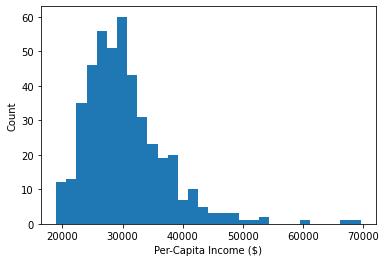

In [92]:
plt.hist(data=df_solfin, x='IncomePerCap', bins=30)
plt.xlabel('Per-Capita Income ($)')
plt.ylabel('Count');

In [93]:
df_solfin['IncomePerCap'].describe()

count      447.000000
mean     30422.706935
std       6734.086545
min      18962.000000
25%      25886.000000
50%      29275.000000
75%      33229.000000
max      69529.000000
Name: IncomePerCap, dtype: float64

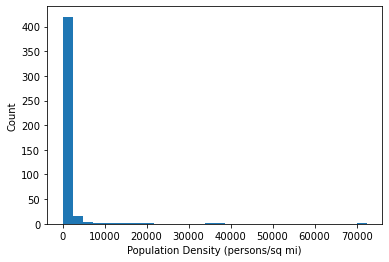

In [94]:
plt.hist(data=df_solfin, x='PopDens', bins=30)
plt.xlabel('Population Density (persons/sq mi)')
plt.ylabel('Count');

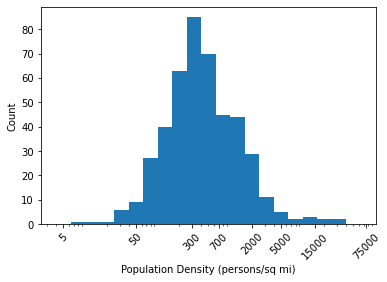

In [95]:
# severely skewed; log-transform
bins = 10**np.arange(0.6,5,0.2)
new_tix = [5, 50, 300, 700, 2000, 5000, 15000, 75000]
new_labs = ['{}'.format(v) for v in new_tix]
plt.hist(data=df_solfin, x='PopDens', bins=bins)
plt.xlabel('Population Density (persons/sq mi)')
plt.xscale('log')
plt.ylabel('Count')
plt.xticks(new_tix, new_labs, rotation=45);

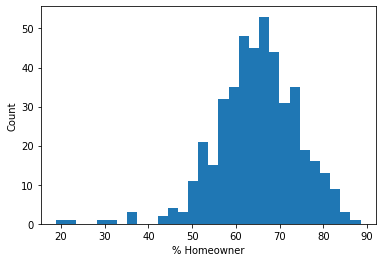

In [96]:
plt.hist(data=df_solfin, x='Pct_hmowner', bins=30)
plt.xlabel('% Homeowner')
plt.ylabel('Count');

In [97]:
df_solfin['Pct_hmowner'].describe()

count    447.000000
mean      64.940045
std        9.434722
min       18.900000
25%       59.850000
50%       65.400000
75%       71.300000
max       88.500000
Name: Pct_hmowner, dtype: float64

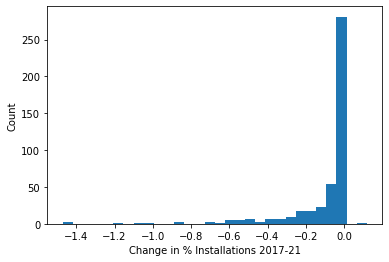

In [98]:
plt.hist(data=df_solfin, x='chg_pct_install', bins=30)
plt.xlabel('Change in % Installations 2017-21')
plt.ylabel('Count');

In [99]:
# get top ten by change in % installs
pct_top10 = df_solfin.sort_values('chg_pct_install', axis=0, ascending=False).iloc[:10,:]
pct_top10

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,kw_median_17,kw_total_17,yearly_sunlight_kwh_total_17,existing_installs_count_17,count_qualified_21,...,existing_installs_count_21,TotalPop,IncomePerCap,StCtyID,land_area_sqmi,Pct_hmowner,PopDens,pct_install_17,pct_install_21,chg_pct_install
4,Alameda County,California,329945,94.675889,88.489606,9.00,6022654.00,8.723122e+09,12126,372309.0,...,14127.0,1629615,41363,06001,739.02,53.0,2205.102704,3.675158,3.794429,0.119271
401,Tuscaloosa County,Alabama,42477,91.844494,81.027412,11.00,932613.25,1.201375e+09,4,41125.0,...,4.0,204424,24895,01125,1321.76,63.3,154.660453,0.009417,0.009726,0.000310
203,Kershaw County,South Carolina,10878,75.483376,78.934765,9.25,192793.25,2.491612e+08,0,12076.0,...,0.0,63734,23530,45055,726.56,81.4,87.720216,0.000000,0.000000,0.000000
102,Daviess County,Kentucky,12839,69.176154,77.972792,9.25,327742.25,4.003984e+08,0,23924.0,...,0.0,99258,26501,21059,458.35,67.5,216.555034,0.000000,0.000000,0.000000
194,Jones County,Mississippi,3902,66.454534,71.860037,10.25,106262.00,1.400114e+08,0,6302.0,...,0.0,68328,20958,28067,694.80,69.3,98.341969,0.000000,0.000000,0.000000
410,Victoria County,Texas,23569,90.585693,92.188845,12.50,496823.75,6.507010e+08,1,24305.0,...,1.0,91518,28181,48469,882.14,68.7,103.745437,0.004243,0.004114,-0.000128
110,Dougherty County,Georgia,23501,96.710872,75.119067,10.75,645679.25,8.527625e+08,14,23640.0,...,14.0,91522,20292,13095,328.69,46.7,278.444735,0.059572,0.059222,-0.000350
92,Craighead County,Arkansas,22769,86.830755,85.035106,10.75,504479.75,6.392150e+08,2,23949.0,...,2.0,104246,25594,05031,707.21,58.6,147.404590,0.008784,0.008351,-0.000433
189,Jefferson County,Arkansas,24389,88.710249,88.580976,11.50,517862.25,6.650119e+08,4,25593.0,...,4.0,71373,20371,05069,870.75,64.4,81.967270,0.016401,0.015629,-0.000772
39,Bradley County,Tennessee,26426,75.804991,87.694963,10.50,535621.75,6.670378e+08,4,27959.0,...,4.0,103666,25144,47011,328.76,64.7,315.324249,0.015137,0.014307,-0.000830


In [149]:
# shorten names for plotting
pct_top10['CtySt'] = pct_top10['region_name'].apply(lambda x: x.replace(' County',', ')) + pct_top10['state_name']
pct_top10

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,kw_median_17,kw_total_17,yearly_sunlight_kwh_total_17,existing_installs_count_17,count_qualified_21,...,TotalPop,IncomePerCap,StCtyID,land_area_sqmi,Pct_hmowner,PopDens,pct_install_17,pct_install_21,chg_pct_install,CtySt
4,Alameda County,California,329945,94.675889,88.489606,9.00,6022654.00,8.723122e+09,12126,372309.0,...,1629615,41363,06001,739.02,53.0,2205.102704,3.675158,3.794429,0.119271,"Alameda, California"
401,Tuscaloosa County,Alabama,42477,91.844494,81.027412,11.00,932613.25,1.201375e+09,4,41125.0,...,204424,24895,01125,1321.76,63.3,154.660453,0.009417,0.009726,0.000310,"Tuscaloosa, Alabama"
203,Kershaw County,South Carolina,10878,75.483376,78.934765,9.25,192793.25,2.491612e+08,0,12076.0,...,63734,23530,45055,726.56,81.4,87.720216,0.000000,0.000000,0.000000,"Kershaw, South Carolina"
102,Daviess County,Kentucky,12839,69.176154,77.972792,9.25,327742.25,4.003984e+08,0,23924.0,...,99258,26501,21059,458.35,67.5,216.555034,0.000000,0.000000,0.000000,"Daviess, Kentucky"
194,Jones County,Mississippi,3902,66.454534,71.860037,10.25,106262.00,1.400114e+08,0,6302.0,...,68328,20958,28067,694.80,69.3,98.341969,0.000000,0.000000,0.000000,"Jones, Mississippi"
410,Victoria County,Texas,23569,90.585693,92.188845,12.50,496823.75,6.507010e+08,1,24305.0,...,91518,28181,48469,882.14,68.7,103.745437,0.004243,0.004114,-0.000128,"Victoria, Texas"
110,Dougherty County,Georgia,23501,96.710872,75.119067,10.75,645679.25,8.527625e+08,14,23640.0,...,91522,20292,13095,328.69,46.7,278.444735,0.059572,0.059222,-0.000350,"Dougherty, Georgia"
92,Craighead County,Arkansas,22769,86.830755,85.035106,10.75,504479.75,6.392150e+08,2,23949.0,...,104246,25594,05031,707.21,58.6,147.404590,0.008784,0.008351,-0.000433,"Craighead, Arkansas"
189,Jefferson County,Arkansas,24389,88.710249,88.580976,11.50,517862.25,6.650119e+08,4,25593.0,...,71373,20371,05069,870.75,64.4,81.967270,0.016401,0.015629,-0.000772,"Jefferson, Arkansas"
39,Bradley County,Tennessee,26426,75.804991,87.694963,10.50,535621.75,6.670378e+08,4,27959.0,...,103666,25144,47011,328.76,64.7,315.324249,0.015137,0.014307,-0.000830,"Bradley, Tennessee"


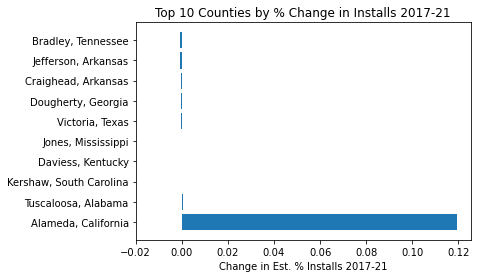

In [145]:
plt.barh(data=pct_top10, y=np.arange(10), width='chg_pct_install', tick_label='CtySt')
plt.title('Top 10 Counties by % Change in Installs 2017-21')
plt.xlabel('Change in Est. % Installs 2017-21')
plt.xticks(np.arange(-0.02, 0.14, 0.02));

In [102]:
# get bottom ten by change in % installs
pct_btm10 = df_solfin.sort_values('chg_pct_install', axis=0, ascending=False).iloc[-10:,:]
pct_btm10

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,kw_median_17,kw_total_17,yearly_sunlight_kwh_total_17,existing_installs_count_17,count_qualified_21,...,existing_installs_count_21,TotalPop,IncomePerCap,StCtyID,land_area_sqmi,Pct_hmowner,PopDens,pct_install_17,pct_install_21,chg_pct_install
357,Santa Clara County,California,365304,89.384158,92.028407,11.00,6672857.50,9.751757e+09,25967,407240.0,...,26167.0,1911226,48689,06085,1290.10,54.9,1481.455701,7.108326,6.425449,-0.682877
389,Sumter County,Florida,12029,59.129791,94.064748,15.00,253982.75,3.483036e+08,124,39799.0,...,124.0,116754,33168,12119,546.93,88.5,213.471559,1.030842,0.311566,-0.719277
213,Lake County,Florida,55672,72.911793,88.864768,13.75,1184074.00,1.609898e+09,1225,90288.0,...,1224.0,326215,25991,12069,938.38,73.4,347.636352,2.200388,1.355662,-0.844726
250,Marin County,California,62120,92.918646,80.622972,9.75,946696.25,1.333770e+09,6130,67983.0,...,6120.0,260814,66748,06041,520.31,62.0,501.266553,9.867997,9.002251,-0.865747
254,Maui County,Hawaii,25736,66.025866,91.158969,12.50,513680.50,7.906587e+08,2636,28060.0,...,2629.0,164094,32379,15009,1161.52,60.8,141.275226,10.242462,9.369209,-0.873253
314,Placer County,California,97204,74.409411,89.191892,11.25,1549769.00,2.202600e+09,8916,111808.0,...,9141.0,374985,39734,06061,1407.01,72.3,266.511965,9.172462,8.175622,-0.996840
167,Hernando County,Florida,29098,71.793277,90.053231,13.75,575166.75,7.816476e+08,670,54906.0,...,670.0,179144,23495,12053,472.54,80.8,379.108647,2.302564,1.220267,-1.082296
37,Boulder County,Colorado,38779,56.507248,68.277696,5.75,587998.75,7.841100e+08,3783,44589.0,...,3830.0,316782,42119,08013,726.29,61.6,436.164617,9.755280,8.589562,-1.165717
412,Volusia County,Florida,107028,69.982391,88.006315,12.00,2026519.00,2.739409e+09,4151,171675.0,...,4150.0,518660,25871,12127,1101.03,71.6,471.068000,3.878424,2.417358,-1.461066
262,Middlesex County,New Jersey,89845,56.448600,78.036515,6.25,1813816.25,2.120464e+09,2659,178638.0,...,2658.0,837288,36558,34023,308.91,63.5,2710.459357,2.959541,1.487925,-1.471616


In [123]:
# shorten names for plotting
pct_btm10['CtySt'] = pct_btm10['region_name'].apply(lambda x: x.replace(' County',', ')) + pct_btm10['state_name']

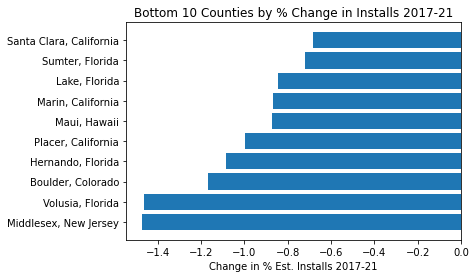

In [161]:
plt.barh(data=pct_btm10, y=np.arange(10,0,-1), width='chg_pct_install', tick_label='CtySt')
plt.title('Bottom 10 Counties by % Change in Installs 2017-21')
plt.xlabel('Change in % Est. Installs 2017-21');

count    447.000000
mean      -6.205477
std       10.335908
min      -43.761307
25%      -12.321200
50%       -4.989752
75%       -1.302146
max       40.415733
Name: chg_pct_covered, dtype: float64

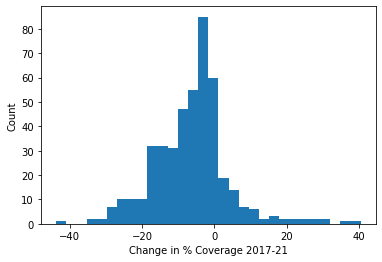

In [125]:
# the changes are tiny and mostly negative
# is this mainly because of more coverage and/or identification of more eligible roofs?
# coverage
df_solfin['chg_pct_covered'] = df_solfin['percent_covered_21'] - df_solfin['percent_covered_17']
display(df_solfin['chg_pct_covered'].describe())
plt.hist(data=df_solfin, x='chg_pct_covered', bins=30)
plt.xlabel('Change in % Coverage 2017-21')
plt.ylabel('Count');

count       447.000000
mean      13066.863535
std       22448.467437
min       -1352.000000
25%        3022.500000
50%        6125.000000
75%       13814.000000
max      232179.000000
Name: chg_qualified, dtype: float64

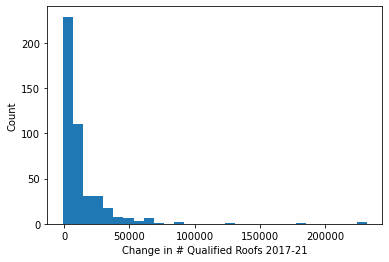

In [126]:
# qualified roofs
df_solfin['chg_qualified'] = df_solfin['count_qualified_21'] - df_solfin['count_qualified_17']
display(df_solfin['chg_qualified'].describe())
plt.hist(data=df_solfin, x='chg_qualified', bins=30)
plt.xlabel('Change in # Qualified Roofs 2017-21')
plt.ylabel('Count');

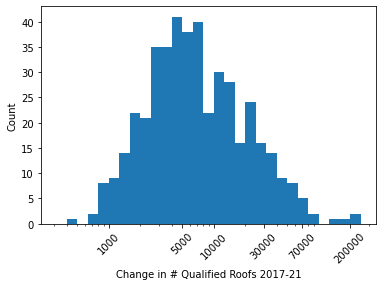

In [127]:
# log transform due to R-skewness
bins = 10**np.arange(2.5,5.5,0.1)
new_tix = [1000, 5000, 10000, 30000, 70000, 200000]
new_labs = ['{}'.format(v) for v in new_tix]
plt.hist(data=df_solfin, x='chg_qualified', bins=bins)
plt.xlabel('Change in # Qualified Roofs 2017-21')
plt.xscale('log')
plt.ylabel('Count')
plt.xticks(new_tix, new_labs, rotation=45);

count    447.000000
mean      19.897016
std       24.771201
min       -3.182899
25%        7.278522
50%       10.718752
75%       19.547587
max      230.858758
Name: chg_qualified_pct, dtype: float64

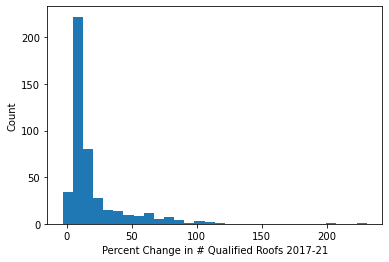

In [128]:
# qualified roofs as % of 2017 value
df_solfin['chg_qualified_pct'] = 100.0*df_solfin['chg_qualified']/df_solfin['count_qualified_17']
display(df_solfin['chg_qualified_pct'].describe())
plt.hist(data=df_solfin, x='chg_qualified_pct', bins=30)
plt.xlabel('Percent Change in # Qualified Roofs 2017-21')
plt.ylabel('Count');

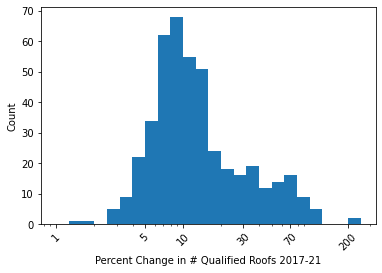

In [129]:
# log transform due to R-skewness
bins = 10**np.arange(0,2.5,0.1)
new_tix = [1, 5, 10, 30, 70, 200]
new_labs = ['{}'.format(v) for v in new_tix]
plt.hist(data=df_solfin, x='chg_qualified_pct', bins=bins)
plt.xlabel('Percent Change in # Qualified Roofs 2017-21')
plt.xscale('log')
plt.ylabel('Count')
plt.xticks(new_tix, new_labs, rotation=45);

#### Mulitvariate

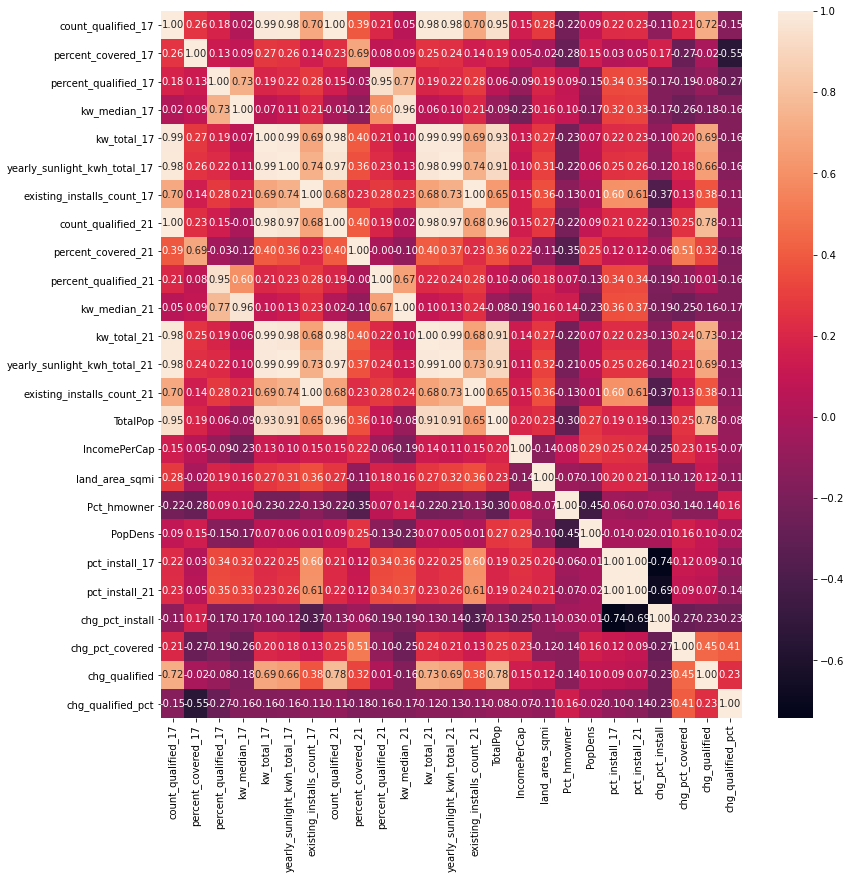

In [130]:
fig, heat = plt.subplots(figsize = (13,13))
heat = sb.heatmap(df_solfin.corr(), annot=True, fmt='.2f');

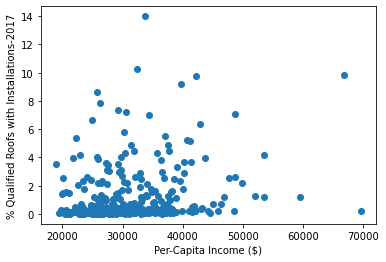

In [131]:
# first variable of interest: per-capita income
plt.scatter(data=df_solfin, x='IncomePerCap', y='pct_install_17')
plt.xlabel('Per-Capita Income ($)')
plt.ylabel('% Qualified Roofs with Installations-2017');

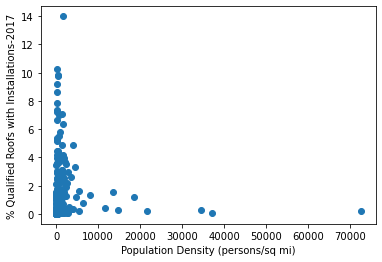

In [132]:
# second variable of interest: population density
plt.scatter(data=df_solfin, x='PopDens', y='pct_install_17')
plt.xlabel('Population Density (persons/sq mi)')
plt.ylabel('% Qualified Roofs with Installations-2017');

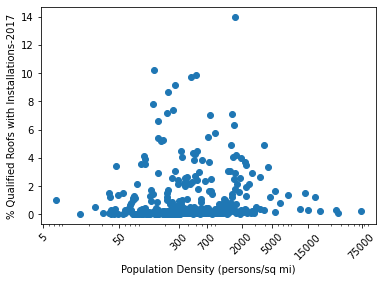

In [133]:
# redo the above with x on a log scale
new_tix = [5, 50, 300, 700, 2000, 5000, 15000, 75000]
new_labs = ['{}'.format(v) for v in new_tix]
plt.scatter(data=df_solfin, x='PopDens', y='pct_install_17')
plt.xlabel('Population Density (persons/sq mi)')
plt.ylabel('% Qualified Roofs with Installations-2017')
plt.xscale('log')
plt.xticks(new_tix, new_labs, rotation=45);

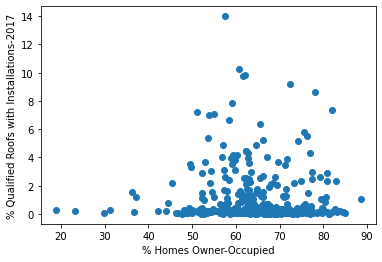

In [136]:
# third variable of interest: % homeowner
plt.scatter(data=df_solfin, x='Pct_hmowner', y='pct_install_17')
plt.xlabel('% Homes Owner-Occupied')
plt.ylabel('% Qualified Roofs with Installations-2017');

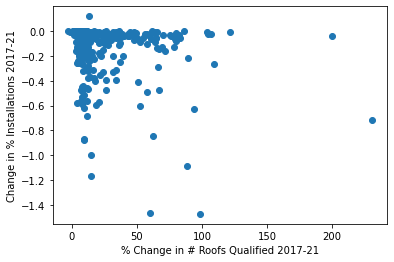

In [137]:
# visualize relationship between % change in qualified roofs and change in % installs
plt.scatter(data=df_solfin, x='chg_qualified_pct', y='chg_pct_install')
plt.xlabel('% Change in # Roofs Qualified 2017-21')
plt.ylabel('Change in % Installations 2017-21');

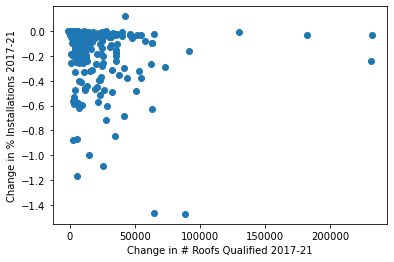

In [138]:
# visualize relationship between change in # qualified roofs and change in % installs
plt.scatter(data=df_solfin, x='chg_qualified', y='chg_pct_install')
plt.xlabel('Change in # Roofs Qualified 2017-21')
plt.ylabel('Change in % Installations 2017-21');

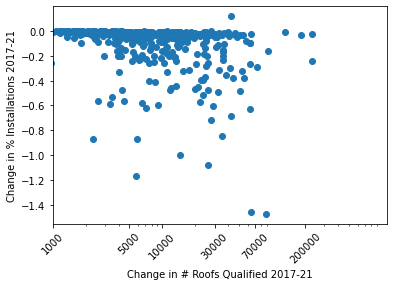

In [139]:
# log-transform last plot due R-skewness
new_tix = [1000, 5000, 10000, 30000, 70000, 200000]
new_labs = ['{}'.format(v) for v in new_tix]
plt.scatter(data=df_solfin, x='chg_qualified', y='chg_pct_install')
plt.xlabel('Change in # Roofs Qualified 2017-21')
plt.ylabel('Change in % Installations 2017-21')
plt.xscale('log')
plt.xticks(new_tix, new_labs, rotation=45);

#### Modeling

There doesn't appear to be a strong relationship between any of the variables of interest and prevalence of solar installations, but will verify by attempting to fit a multivariate linear regression

In [140]:
#Split into explanatory and response variables
X = df_solfin[['IncomePerCap', 'PopDens', 'Pct_hmowner']]
y = df_solfin['pct_install_17']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
r2_test = lm_model.score(X_test, y_test) 
"The r-squared score for your model was {} on {} values.".format(r2_test, len(y_test))

'The r-squared score for your model was -0.053680057641551704 on 135 values.'

In [141]:
# take a look at the linear regression coefficients
lm_model.coef_

array([ 9.54930926e-05, -6.86260034e-05, -3.26149270e-02])

#### Presentation

Create final plots for README and blog post.

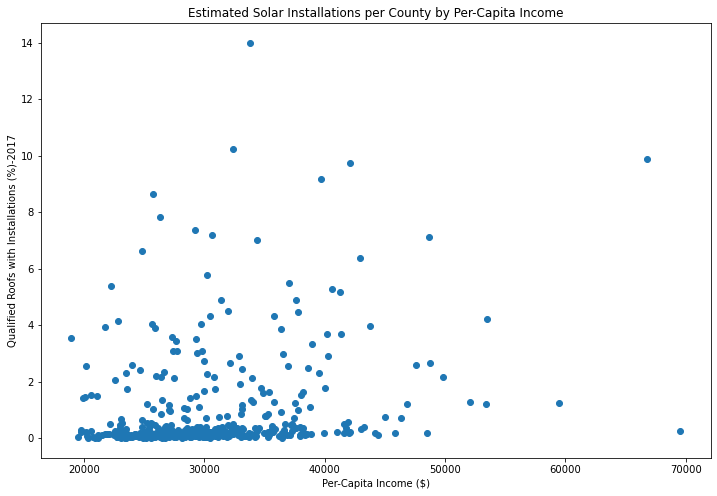

In [154]:
fig1, scat1 = plt.subplots(figsize = (12,8))
scat1 = plt.scatter(data=df_solfin, x='IncomePerCap', y='pct_install_17')
plt.xlabel('Per-Capita Income ($)')
plt.ylabel('Qualified Roofs with Installations (%)-2017')
plt.title('Estimated Solar Installations per County by Per-Capita Income');

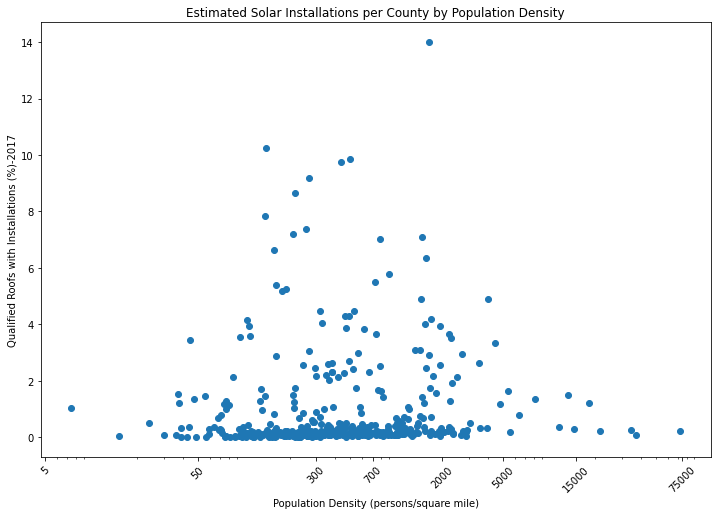

In [155]:
fig2, scat2 = plt.subplots(figsize = (12,8))
scat2 = plt.scatter(data=df_solfin, x='PopDens', y='pct_install_17')
new_tix = [5, 50, 300, 700, 2000, 5000, 15000, 75000]
new_labs = ['{}'.format(v) for v in new_tix]
plt.xlabel('Population Density (persons/square mile)')
plt.ylabel('Qualified Roofs with Installations (%)-2017')
plt.xscale('log')
plt.xticks(new_tix, new_labs, rotation=45);
plt.title('Estimated Solar Installations per County by Population Density');

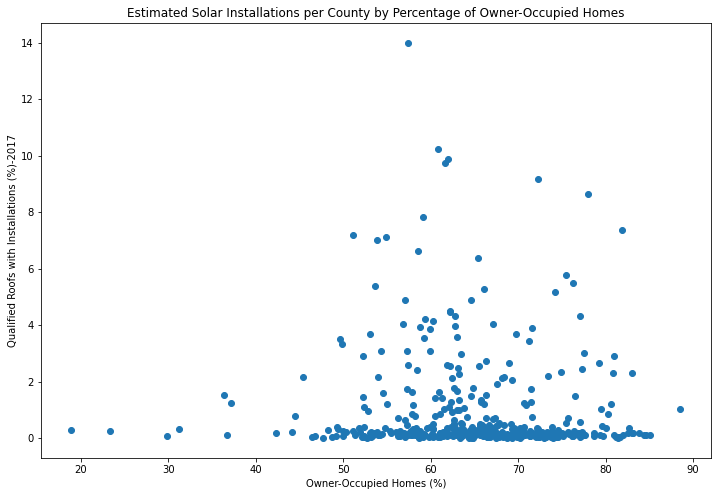

In [157]:
# third variable of interest: % homeowner
fig3, scat3 = plt.subplots(figsize = (12,8))
scat3 = plt.scatter(data=df_solfin, x='Pct_hmowner', y='pct_install_17')
plt.xlabel('Owner-Occupied Homes (%)')
plt.ylabel('Qualified Roofs with Installations (%)-2017')
plt.title('Estimated Solar Installations per County by Percentage of Owner-Occupied Homes');

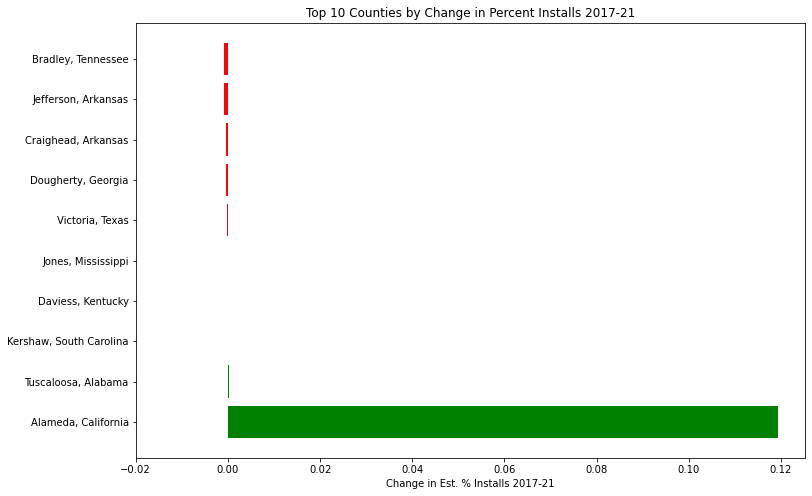

In [164]:
fig4, bar1 = plt.subplots(figsize = (12,8))
pct_top10['negpos'] = pct_top10['chg_pct_install'] < 0
bar1 = plt.barh(data=pct_top10, y=np.arange(10), width='chg_pct_install', tick_label='CtySt',\
               color=pct_top10['negpos'].map({True:'r', False:'g'}))
plt.title('Top 10 Counties by Change in Percent Installs 2017-21')
plt.xlabel('Change in Est. % Installs 2017-21')
plt.xticks(np.arange(-0.02, 0.14, 0.02));

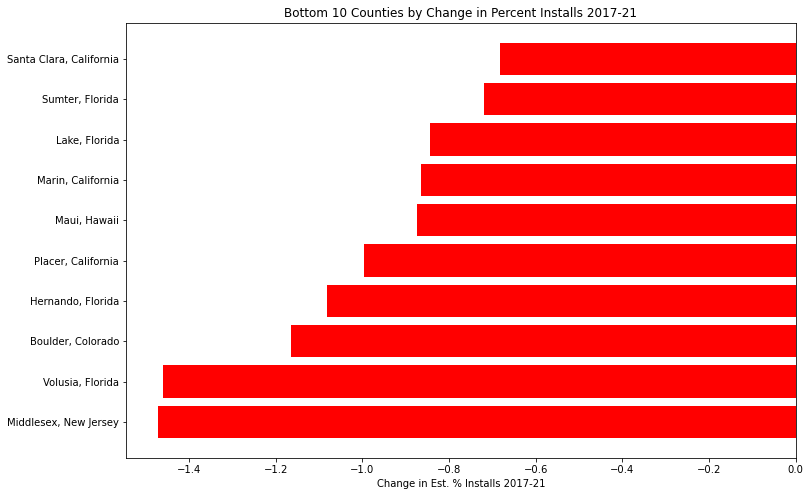

In [165]:
fig5, bar2 = plt.subplots(figsize = (12,8))
pct_btm10['negpos'] = pct_btm10['chg_pct_install'] < 0
bar1 = plt.barh(data=pct_btm10, y=np.arange(10,0,-1), width='chg_pct_install', tick_label='CtySt',\
               color=pct_btm10['negpos'].map({True:'r', False:'g'}))
plt.title('Bottom 10 Counties by Change in Percent Installs 2017-21')
plt.xlabel('Change in Est. % Installs 2017-21');

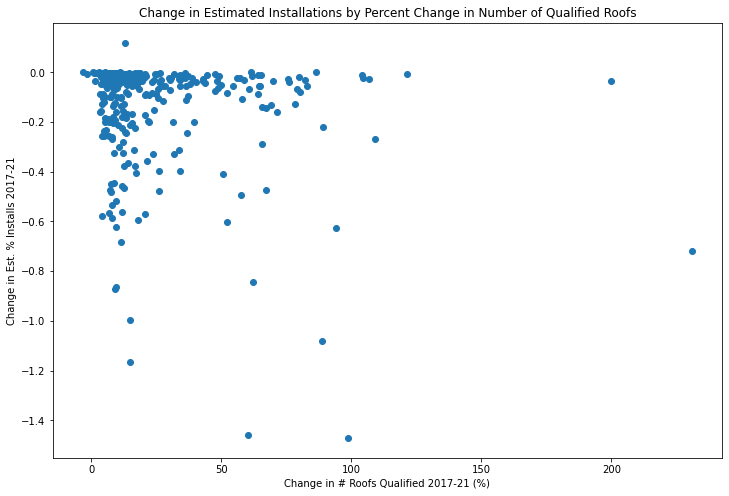

In [167]:
# visualize relationship between % change in qualified roofs and change in % installs
fig6, scat4 = plt.subplots(figsize = (12,8))
scat4 = plt.scatter(data=df_solfin, x='chg_qualified_pct', y='chg_pct_install')
plt.xlabel('Change in # Roofs Qualified 2017-21 (%)')
plt.ylabel('Change in Est. % Installs 2017-21')
plt.title('Change in Estimated Installations by Percent Change in Number of Qualified Roofs');

In [172]:
# save the final data
df_solfin.to_csv('solar_final.csv')

In [174]:
df_solfin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447 entries, 0 to 446
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   region_name                   447 non-null    object 
 1   state_name                    447 non-null    object 
 2   count_qualified_17            447 non-null    int64  
 3   percent_covered_17            447 non-null    float64
 4   percent_qualified_17          447 non-null    float64
 5   kw_median_17                  447 non-null    float64
 6   kw_total_17                   447 non-null    float64
 7   yearly_sunlight_kwh_total_17  447 non-null    float64
 8   existing_installs_count_17    447 non-null    int64  
 9   count_qualified_21            447 non-null    float64
 10  percent_covered_21            447 non-null    float64
 11  percent_qualified_21          447 non-null    float64
 12  kw_median_21                  447 non-null    float64
 13  kw_to